In [ ]:
# 🧠 Multimodal Sentiment Alignment using CLIP and BERT  

## ✨ Key Findings

- **Positive captions** showed marginally stronger alignment with images than negative or neutral.
- **Neutral captions**, when vague, exhibited the weakest alignment—but the most well-aligned samples were surprisingly neutral.
- **Dunn's post-hoc test** revealed that **neutral vs. negative** alignment differences were statistically significant (*p < 0.01*).
- **t-SNE clustering** revealed coherent semantic structures, and topic clusters such as *urban scenes*, *animals*, and *food* emerged.
- **Image clusters** revealed that visual similarity doesn't necessarily reflect sentiment similarity.

---

## 🧪 Environment Setup

We recommend creating a virtual environment or using Conda.

```bash
# Create and activate environment (optional)
python3 -m venv venv
source venv/bin/activate  # Mac/Linux
venv\Scripts\activate     # Windows

# Install required packages
pip install -r requirements.txt
pip install pandas numpy matplotlib seaborn scikit-learn plotly
pip install torch torchvision
pip install openai clip-by-openai
pip install transformers
pip install nltk tqdm
                                                                                                       
⚠️ Due to size limitations, the original `val2017` image dataset is not included in this repository.
You can download it separately from the official COCO dataset page: https://cocodataset.org/#download                                                                                                      

# Set paths
image_folder = "/Users/sanakhan/Desktop/val2017"
caption_file = "/Users/sanakhan/Desktop/annotations/captions_val2017.json" - Please change to your path
                                                                                                       

In [ ]:
#### Data Loading and Checking ####

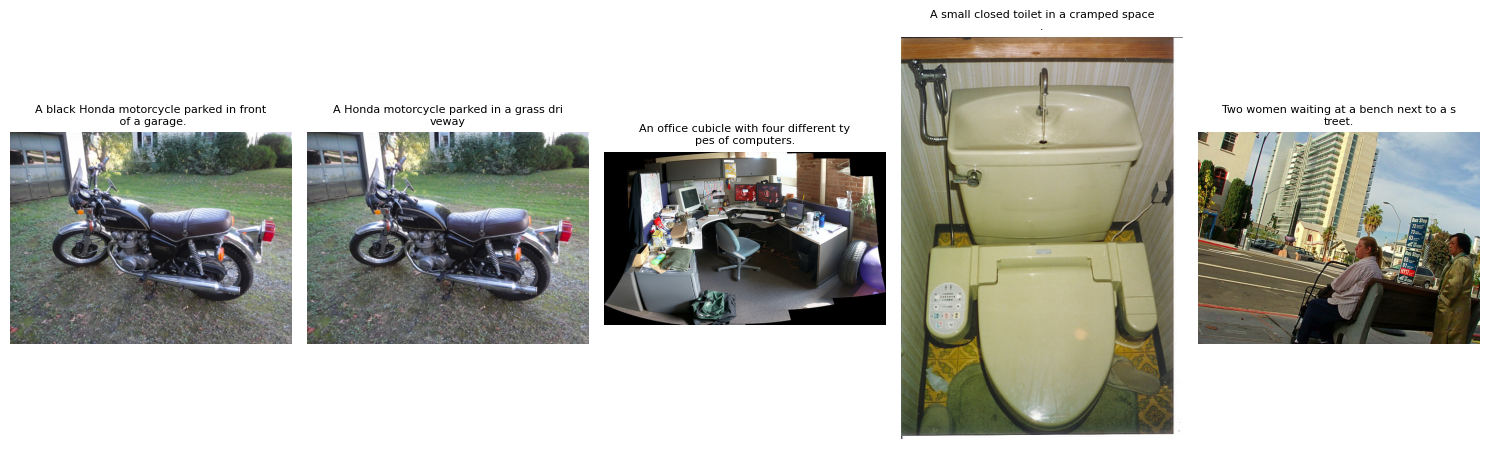

In [1]:
import json
import os
from PIL import Image
import matplotlib.pyplot as plt

# Set paths
image_folder = "/Users/sanakhan/Desktop/val2017"
caption_file = "/Users/sanakhan/Desktop/annotations/captions_val2017.json"

# Load captions JSON
with open(caption_file, 'r') as f:
    data = json.load(f)

# Create a mapping from image ID to file name
id_to_filename = {img["id"]: img["file_name"] for img in data["images"]}

# Preview 5 image-caption pairs
plt.figure(figsize=(15, 10))

for i, annotation in enumerate(data["annotations"][:5]):
    image_id = annotation["image_id"]
    caption = annotation["caption"]
    image_filename = id_to_filename[image_id]
    image_path = os.path.join(image_folder, image_filename)

    img = Image.open(image_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("\n".join(caption[i:i+40] for i in range(0, len(caption), 40)), fontsize=8)

plt.tight_layout()
plt.show()

In [3]:
pip install transformers torch --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Step 5: Load RoBERTa-based sentiment model to classify captions into positive, neutral, or negative#

In [ ]:
# STEP 1: Install required packages (only once)
# Run this in a terminal cell or first code block:
# !pip install transformers torch --quiet

# STEP 2: Import libraries
import json
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [11]:

# STEP 3: Set paths to your dataset
caption_file = "/Users/sanakhan/Desktop/annotations/captions_val2017.json"

# STEP 4: Load JSON and extract captions
with open(caption_file, 'r') as f:
    data = json.load(f)

captions = pd.DataFrame(data['annotations'])[['image_id', 'caption']].sample(2000, random_state=42)

# STEP 5: Load pretrained sentiment model
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

labels = ['negative', 'neutral', 'positive']

# STEP 6: Sentiment analysis function
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = softmax(outputs.logits.numpy()[0])
    return labels[probs.argmax()]

# STEP 7: Apply sentiment labeling
captions['sentiment'] = captions['caption'].apply(get_sentiment)

# STEP 8: Save output
captions.to_csv("captions_with_sentiment.csv", index=False)
print("✅ Done! Saved 2000 annotated captions to 'captions_with_sentiment.csv'")

✅ Done! Saved 2000 annotated captions to 'captions_with_sentiment.csv'


In [13]:
captions['sentiment'].value_counts()

sentiment
neutral     1812
negative     101
positive      87
Name: count, dtype: int64

In [ ]:
# Step 6: Use BERT-based multilingual model to generate 1–5 star ratings, then map to sentiment labels#

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

# Load new sentiment model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Re-define the sentiment function
def get_star_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = softmax(outputs.logits.numpy()[0])
        stars = probs.argmax() + 1  # Convert 0-4 to 1-5 stars
        return stars

# Apply to your captions
captions['stars'] = captions['caption'].apply(get_star_sentiment)

# Optional: Map to simplified labels 'positive/neutral/negative'
def map_star_to_sentiment(stars):
    if stars >= 4:
        return "positive"
    elif stars == 3:
        return "neutral"
    else:
        return "negative"

captions['sentiment'] = captions['stars'].apply(map_star_to_sentiment)

# Save new results
captions.to_csv("captions_with_star_sentiment.csv", index=False)

# Check distribution
print(captions['sentiment'].value_counts())

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

sentiment
positive    1307
negative     357
neutral      336
Name: count, dtype: int64


In [ ]:
## CLIP ANALYSIS ##

In [29]:
!pip install git+https://github.com/openai/CLIP.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/openai/CLIP.git to /private/var/folders/tx/s3lycm555gj6kw7jr74_gzc00000gn/T/pip-req-build-11hwl522
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/tx/s3lycm555gj6kw7jr74_gzc00000gn/T/pip-req-build-11hwl522
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=33b820a0c1f35f101dbc8fc18d5bc4ada9695c98e529152052300b3bb7723645
  Stored in directory: /private/var/folders/tx/s3lycm555gj6kw7jr74_gzc00000gn/T/pip-ephem-wheel-cache-95q0bktr/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [37]:
import clip
import torch
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

df = pd.read_csv("captions_with_star_sentiment.csv")
image_folder = "/Users/sanakhan/Desktop/val2017"

# ✅ Remove limiting line to use full data


image_embeddings = []
text_embeddings = []

print("🔄 Generating image and text embeddings...")
for i, row in tqdm(df.iterrows(), total=len(df)):
    image_path = os.path.join(image_folder, f"{int(row['image_id']):012d}.jpg")
    caption = row["caption"]

    try:
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        text = clip.tokenize([caption]).to(device)

        with torch.no_grad():
            img_embed = model.encode_image(image)
            txt_embed = model.encode_text(text)

        image_embeddings.append(img_embed.cpu().numpy()[0])
        text_embeddings.append(txt_embed.cpu().numpy()[0])
    except Exception as e:
        print(f"⚠️ Skipping {image_path} due to error: {e}")
        continue

print("✅ Embeddings generated!")

🔄 Generating image and text embeddings...


100%|███████████████████████████████████████| 2000/2000 [01:30<00:00, 22.14it/s]

✅ Embeddings generated!


In [39]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert lists to numpy arrays
image_embeddings_np = np.array(image_embeddings)
text_embeddings_np = np.array(text_embeddings)

# Compute cosine similarities
similarities = [cosine_similarity([img], [txt])[0][0] for img, txt in zip(image_embeddings_np, text_embeddings_np)]

# Add to dataframe
captions['clip_similarity'] = similarities

# Save results
captions.to_csv("captions_with_clip_similarity.csv", index=False)

# Check distribution
captions['clip_similarity'].describe()

count    2000.000000
mean        0.304003
std         0.033900
min         0.185124
25%         0.282781
50%         0.304368
75%         0.326668
max         0.413617
Name: clip_similarity, dtype: float64

In [ ]:
# VISUALS FOR COSINE SIMILARITY

/var/folders/tx/s3lycm555gj6kw7jr74_gzc00000gn/T/ipykernel_21837/3690876163.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sentiment", y="clip_similarity", data=df, palette={"positive": "#4c72b0", "neutral": "#55a868", "negative": "#c44e52"})


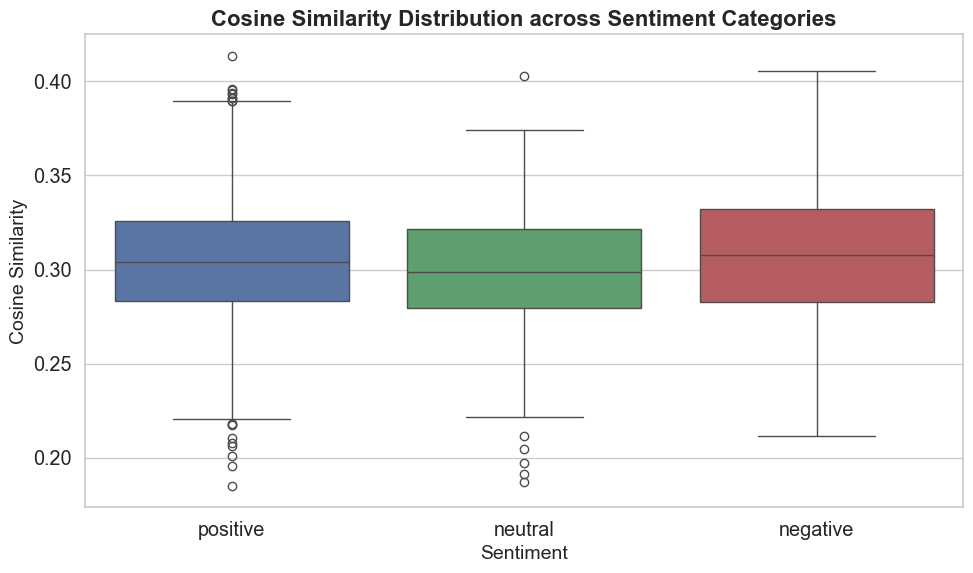

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df contains the 'clip_similarity' and 'sentiment' columns

plt.figure(figsize=(10, 6))

# Create a boxplot to visualize the distribution of cosine similarities
sns.boxplot(x="sentiment", y="clip_similarity", data=df, palette={"positive": "#4c72b0", "neutral": "#55a868", "negative": "#c44e52"})

# Set plot labels
plt.title("Cosine Similarity Distribution across Sentiment Categories", fontsize=16, weight="bold")
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Cosine Similarity", fontsize=14)
plt.tight_layout()

# Save as PNG
plt.savefig("cosine_similarity_distribution.png", dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os

/var/folders/tx/s3lycm555gj6kw7jr74_gzc00000gn/T/ipykernel_21837/372955744.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


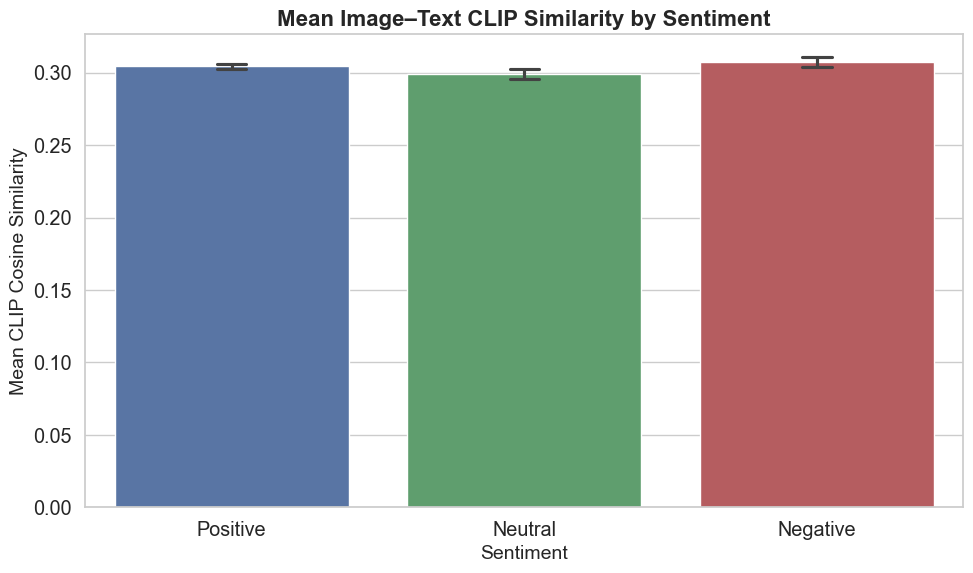

In [53]:
# Load your data
df = pd.read_csv("captions_with_clip_similarity.csv")

# Capitalize sentiment labels for readability
df["sentiment"] = df["sentiment"].str.capitalize()

# Set professional theme and font size
sns.set(style="whitegrid", font_scale=1.3)

# Define elegant color palette
custom_palette = {
    "Positive": "#4C72B0",
    "Neutral": "#55A868",
    "Negative": "#C44E52"
}

plt.figure(figsize=(10, 6))

# Grouped barplot with CI and caps
sns.barplot(
    data=df,
    x="sentiment",
    y="clip_similarity",
    palette=custom_palette,
    errorbar="ci",
    capsize=0.1
)

# Title & labels
plt.title("Mean Image–Text CLIP Similarity by Sentiment", fontsize=16, weight="bold")
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Mean CLIP Cosine Similarity", fontsize=14)
plt.tight_layout()

# Save as high-res PNG
plt.savefig("clip_similarity_barplot_clean.png", dpi=300)
plt.show()

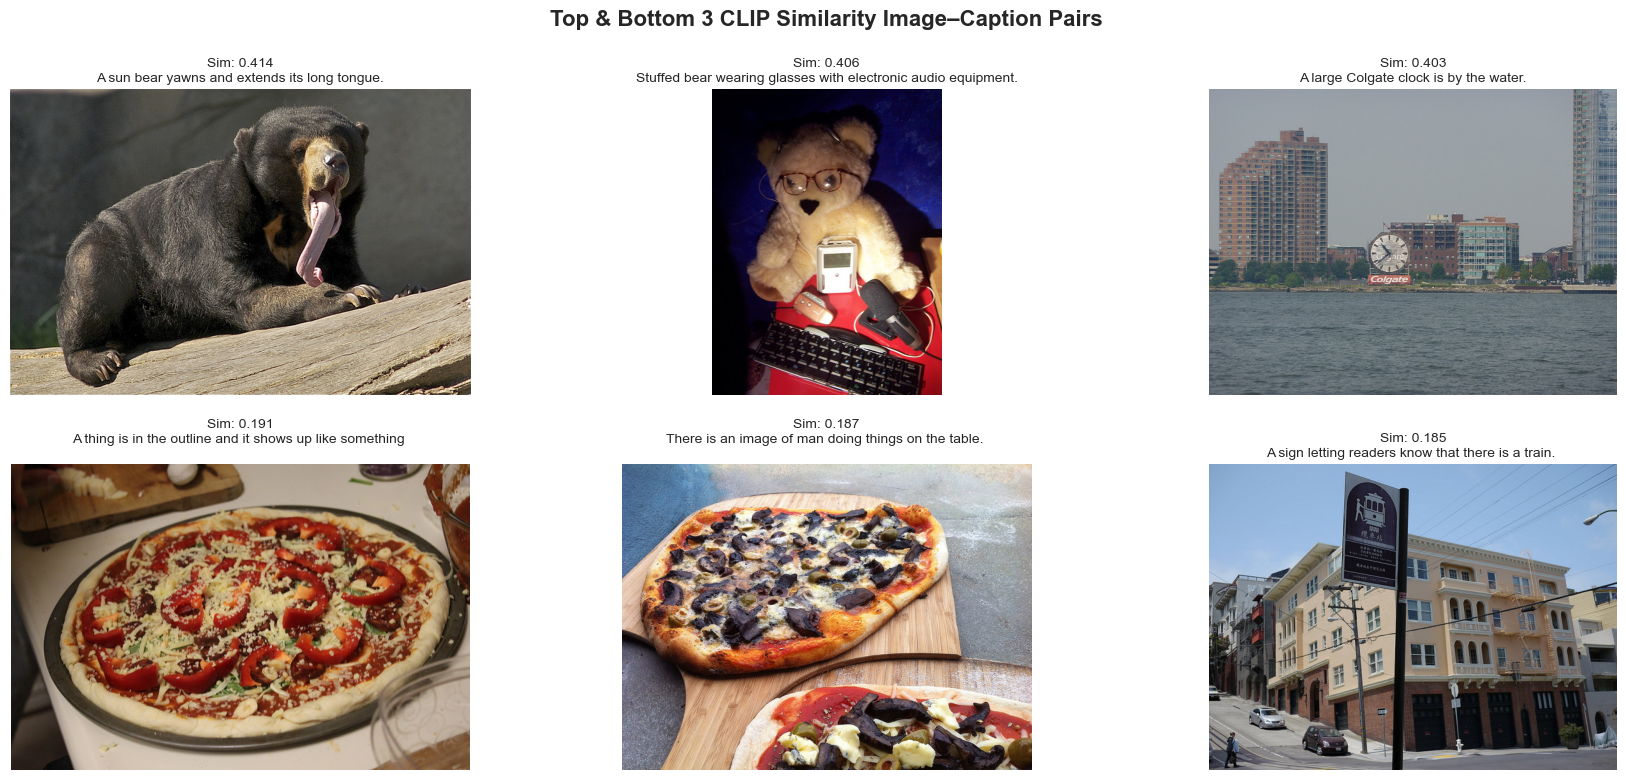

In [55]:
from PIL import Image
import os

# Load the data
df = pd.read_csv("captions_with_clip_similarity.csv")

# Sort by similarity
df_sorted = df.sort_values(by="clip_similarity", ascending=False)

# Top and bottom 3 samples
top3 = df_sorted.head(3)
bottom3 = df_sorted.tail(3)

# Image folder path
image_folder = "/Users/sanakhan/Desktop/val2017"

# Combine top and bottom
extremes = pd.concat([top3, bottom3]).reset_index(drop=True)

# Plot
plt.figure(figsize=(18, 8))

for i, row in extremes.iterrows():
    image_id = int(row['image_id'])
    image_path = os.path.join(image_folder, f"{image_id:012d}.jpg")
    caption = row['caption']
    similarity = row['clip_similarity']
    
    img = Image.open(image_path)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Sim: {similarity:.3f}\n{caption}", fontsize=10)

plt.suptitle("Top & Bottom 3 CLIP Similarity Image–Caption Pairs", fontsize=16, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig("extreme_clip_examples.png", dpi=300)
plt.show()

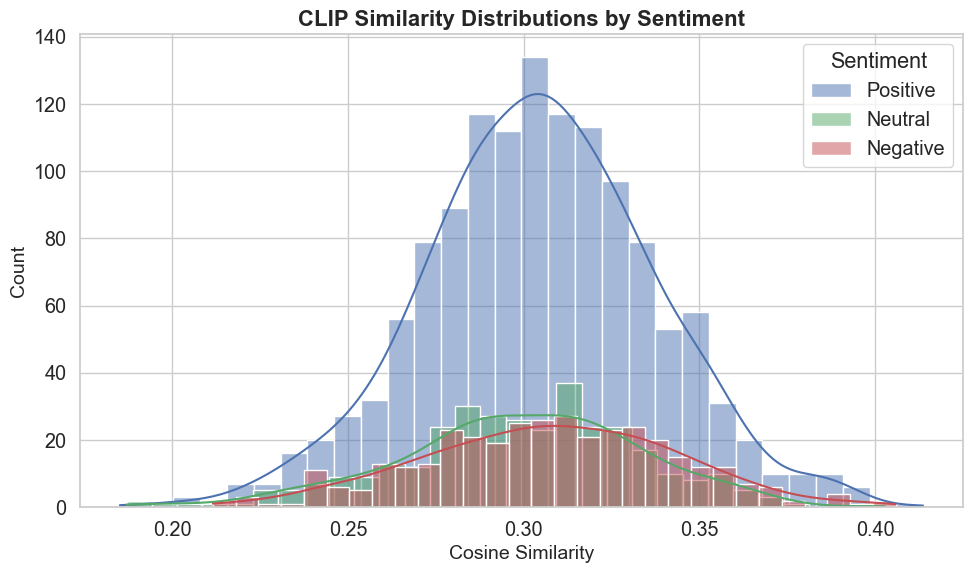

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
df = pd.read_csv("captions_with_clip_similarity.csv")

# Set seaborn style
sns.set(style="whitegrid", font_scale=1.3)

# Custom color palette
custom_palette = {
    "positive": "#4c72b0",
    "neutral": "#55a868",
    "negative": "#c44e52"
}

# Plot
plt.figure(figsize=(10, 6))
for sentiment, color in custom_palette.items():
    subset = df[df['sentiment'] == sentiment]
    sns.histplot(subset['clip_similarity'], kde=True, label=sentiment.capitalize(), color=color, stat="count", bins=30, alpha=0.5)

# Labels and legend
plt.title("CLIP Similarity Distributions by Sentiment", fontsize=16, weight='bold')
plt.xlabel("Cosine Similarity", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Sentiment")
plt.tight_layout()

# Save
plt.savefig("clip_similarity_distribution_customcolors.png", dpi=300)
plt.show()

In [ ]:
# STATISTICAL TESTING AND VISULIZATION 

In [69]:
# Grouped data
pos_sim = df[df['sentiment'] == 'positive']['clip_similarity']
neu_sim = df[df['sentiment'] == 'neutral']['clip_similarity']
neg_sim = df[df['sentiment'] == 'negative']['clip_similarity']

# Perform Kruskal-Wallis test
stat, p = kruskal(pos_sim, neu_sim, neg_sim)
print(f"Kruskal-Wallis H-statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")

# Interpret
if p < 0.05:
    print("✅ Statistically significant difference between sentiment groups.")
else:
    print("⚠️ No significant difference found.")

Kruskal-Wallis H-statistic: 8.7189
P-value: 0.0128
✅ Statistically significant difference between sentiment groups.


In [71]:
!pip install scikit-posthocs

import scikit_posthocs as sp
import pandas as pd

# Prepare the data
df = pd.read_csv("captions_with_clip_similarity.csv")
df_filtered = df[df['sentiment'].isin(['positive', 'neutral', 'negative'])]

# Perform Dunn's test (non-parametric pairwise test)
posthoc = sp.posthoc_dunn(df_filtered, val_col='clip_similarity', group_col='sentiment', p_adjust='bonferroni')

# Display as table
print("📊 Pairwise Post-Hoc Test (Dunn's Test with Bonferroni Correction)")
print(posthoc.round(4))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


📊 Pairwise Post-Hoc Test (Dunn's Test with Bonferroni Correction)
          negative  neutral  positive
negative    1.0000   0.0099    0.3361
neutral     0.0099   1.0000    0.1070
positive    0.3361   0.1070    1.0000


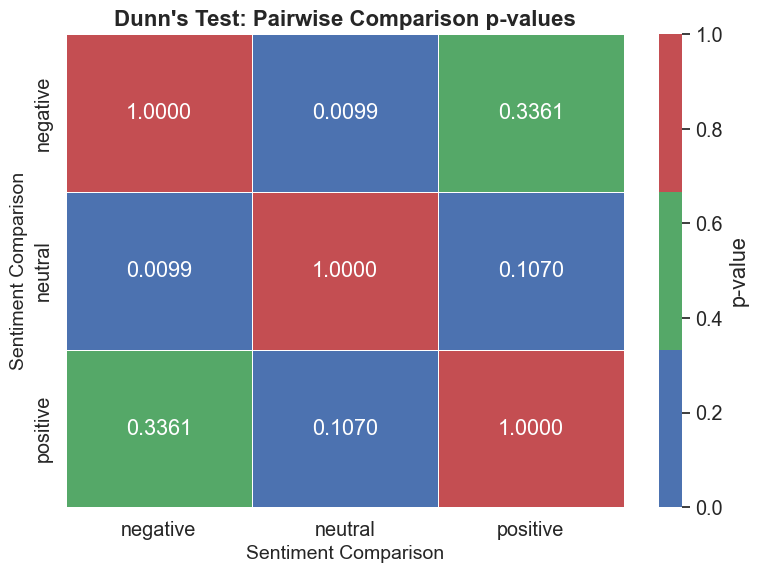

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Pairwise p-values from Dunn's test
p_values = {
    'negative': {'negative': 1.0000, 'neutral': 0.0099, 'positive': 0.3361},
    'neutral': {'negative': 0.0099, 'neutral': 1.0000, 'positive': 0.1070},
    'positive': {'negative': 0.3361, 'neutral': 0.1070, 'positive': 1.0000}
}

# Convert the p-values into a DataFrame for heatmap plotting
p_values_df = pd.DataFrame(p_values)

# Define the custom color palette using the new colors
custom_palette = {
    "positive": "#4c72b0",  # Blue for positive
    "neutral": "#55a868",   # Green for neutral
    "negative": "#c44e52"   # Red for negative
}

# Create a heatmap with the custom colors
plt.figure(figsize=(8, 6))
sns.heatmap(p_values_df, annot=True, cmap=sns.color_palette(list(custom_palette.values()), as_cmap=True), fmt=".4f", linewidths=0.5, cbar_kws={'label': 'p-value'}, vmin=0, vmax=1)

# Title and labels
plt.title("Dunn's Test: Pairwise Comparison p-values", fontsize=16, weight="bold")
plt.xlabel("Sentiment Comparison", fontsize=14)
plt.ylabel("Sentiment Comparison", fontsize=14)

# Save the heatmap as a PNG file
plt.tight_layout()
plt.savefig("dunns_test_heatmap.png", dpi=300)

# Show the plot
plt.show()

In [ ]:
### KMEANS CLUSTERING FOR CAPTIONS AND IMAGES

In [93]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming text_embeddings already exists as a list of embeddings
text_embeddings_np = np.array(text_embeddings)

# Set number of clusters
num_clusters = 5

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(text_embeddings_np)

print("✅ Clusters assigned to captions!")
df[['caption', 'sentiment', 'cluster']].head()

✅ Clusters assigned to captions!


NameError: name 'TfidfVectorizer' is not defined

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Group by cluster
cluster_summaries = {}

# Loop through each cluster
for i in range(df['cluster'].nunique()):
    cluster_captions = df[df['cluster'] == i]['caption']
    
    # Create TF-IDF matrix for captions in this cluster
    vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
    tfidf_matrix = vectorizer.fit_transform(cluster_captions)
    
    # Get top terms
    terms = vectorizer.get_feature_names_out()
    cluster_summaries[i] = terms

# Print summaries
print("🧠 TL;DR Summary of Caption Clusters:\n")
for cluster_id, keywords in cluster_summaries.items():
    print(f"Cluster {cluster_id}: {', '.join(keywords)}\n")

🧠 TL;DR Summary of Caption Clusters:

Cluster 0: building, buildings, bus, cars, city, clock, large, near, parked, people, red, road, sign, sitting, stop, street, tracks, train, truck, yellow

Cluster 1: baseball, dog, food, group, kitchen, looking, man, people, person, phone, picture, pizza, plate, playing, room, sitting, standing, table, tennis, woman

Cluster 2: baseball, beach, boy, holding, man, people, person, playing, riding, skateboard, snow, standing, tennis, umbrella, walking, wave, wearing, white, woman, young

Cluster 3: bathroom, bed, cat, computer, desk, dog, kitchen, laptop, large, living, man, pizza, plate, room, sink, sitting, small, table, toilet, white

Cluster 4: bear, brown, elephant, elephants, fence, field, giraffe, giraffes, grass, green, group, large, near, sheep, standing, tree, walking, white, zebra, zebras



In [89]:
# Explore sample captions from each cluster
for i in range(5):
    print(f"\n🧠 Cluster {i} Examples:")
    display(df[df['cluster'] == i][['caption', 'sentiment']].sample(5, random_state=42))


🧠 Cluster 0 Examples:


caption sentiment
800   a collage with nine fire hydrants of different...  positive
1950  An airplane with the Swiss flag symbol is flyi...  positive
1792  A large blue bus is driving down a crowded str...  positive
1264  A blue bus makes its way down a narrow city st...  positive
784   Several cars travelling on a street with sever...   neutral


🧠 Cluster 1 Examples:


caption sentiment
1782  Looking down at the spectators and players dur...  positive
213        a couple of tennis players on a tennis court   neutral
96    Two plates of breakfast food and a glass of ju...  negative
1699          a dog is jumping in the air toward a disk  negative
355   A person is sitting behind a curtain with anot...  negative


🧠 Cluster 2 Examples:


caption sentiment
272   A shirtless man doing skateboarding tricks nea...  positive
965   a large bird catching a gray from in shallow w...   neutral
1802      A group of four older men posing for a photo.   neutral
302   A man about to hit a tennis ball in front of a...  positive
1678  A soccer game with players from both teams goi...   neutral


🧠 Cluster 3 Examples:


caption sentiment
1714  A plastic tree with a doughnut hanging by a st...  positive
1985  Several pieces of bread sitting on a grill wit...   neutral
698         A man and a woman eat doughnuts from a box.  positive
578    A leather sitting bench is in a dimly lit room.   positive
1554  A kitchen with hardwood floors and a sink and ...  positive


🧠 Cluster 4 Examples:


caption sentiment
996   Two giraffes in a sanctuary standing close to ...  positive
177                A flock of birds flies over a beach.  positive
317   A polar bear opening its mouth while standing ...  negative
1552  Three giraffes stand by a sparse tree in the b...   neutral
1326         a brown cow is standing under a green tree   neutral

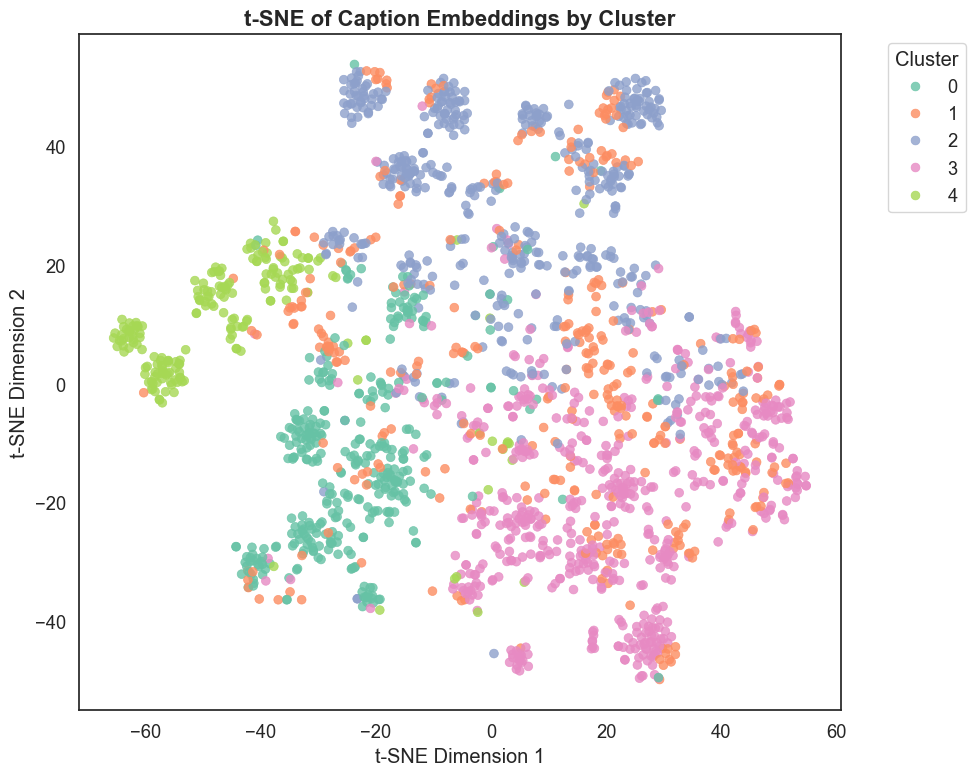

In [97]:

# Professional settings
sns.set(style="white", font_scale=1.2)
plt.figure(figsize=(10, 8))

# Plot t-SNE with color based on cluster only
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=df['cluster'],
    palette="Set2",
    s=40,
    alpha=0.8,
    edgecolor=None,
    legend="full"
)

plt.title("t-SNE of Caption Embeddings by Cluster", fontsize=16, weight="bold")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save
plt.savefig("tsne_caption_clusters.png", dpi=300)
plt.show()

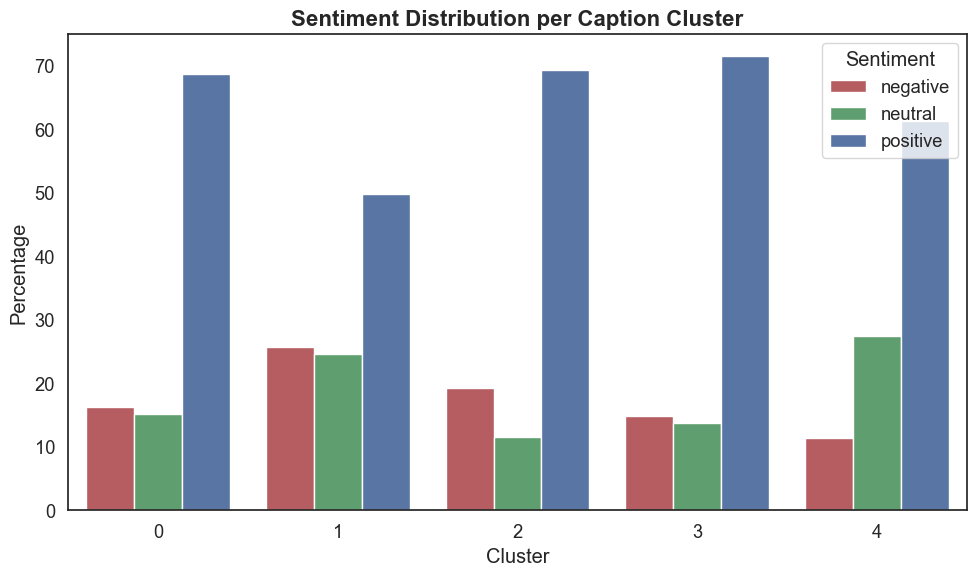

In [99]:
# Calculate proportions
sentiment_cluster = df.groupby(['cluster', 'sentiment']).size().reset_index(name='count')
total_per_cluster = sentiment_cluster.groupby('cluster')['count'].transform('sum')
sentiment_cluster['percentage'] = sentiment_cluster['count'] / total_per_cluster * 100

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=sentiment_cluster,
    x='cluster',
    y='percentage',
    hue='sentiment',
    palette={
        'positive': "#4c72b0",
        'neutral': "#55a868",
        'negative': "#c44e52"
    }
)
plt.title("Sentiment Distribution per Caption Cluster", fontsize=16, weight="bold")
plt.ylabel("Percentage")
plt.xlabel("Cluster")
plt.legend(title="Sentiment")
plt.tight_layout()

# Save
plt.savefig("sentiment_by_cluster_barplot.png", dpi=300)
plt.show()

In [101]:
image_embeddings_np = np.array(image_embeddings)

In [109]:
from sklearn.cluster import KMeans

num_img_clusters = 5  # or experiment with 4–6
kmeans_img = KMeans(n_clusters=num_img_clusters, random_state=42)
df['image_cluster'] = kmeans_img.fit_predict(image_embeddings_np)

print("✅ Image clusters assigned!")
df.to_csv("captions_with_clip_similarity.csv", index=False)

✅ Image clusters assigned!


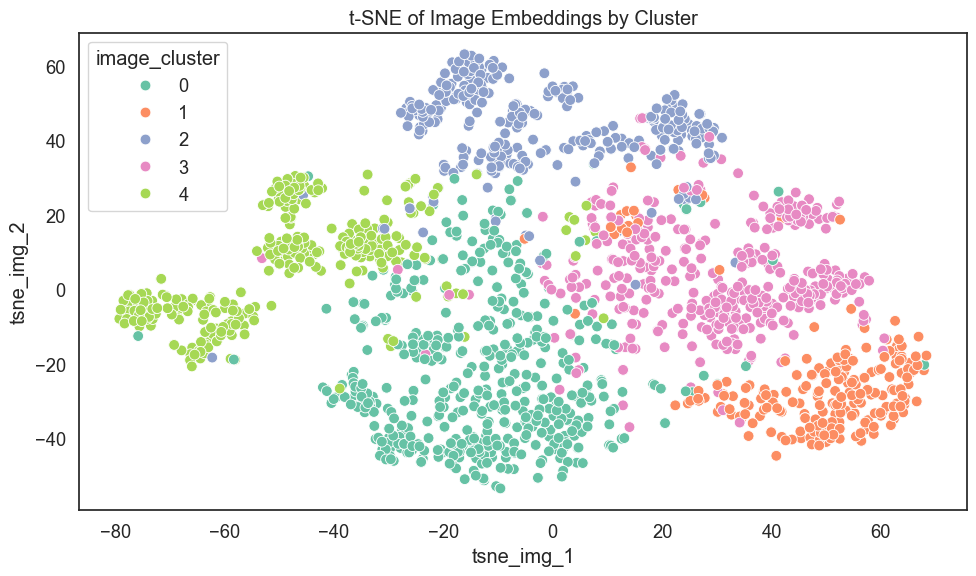

In [105]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne_img = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_img_proj = tsne_img.fit_transform(image_embeddings_np)

df['tsne_img_1'] = tsne_img_proj[:, 0]
df['tsne_img_2'] = tsne_img_proj[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='tsne_img_1', y='tsne_img_2',
    hue='image_cluster',
    palette='Set2',
    s=60
)
plt.title("t-SNE of Image Embeddings by Cluster")
plt.tight_layout()
plt.savefig("image_tsne_clusters.png", dpi=300)
plt.show()

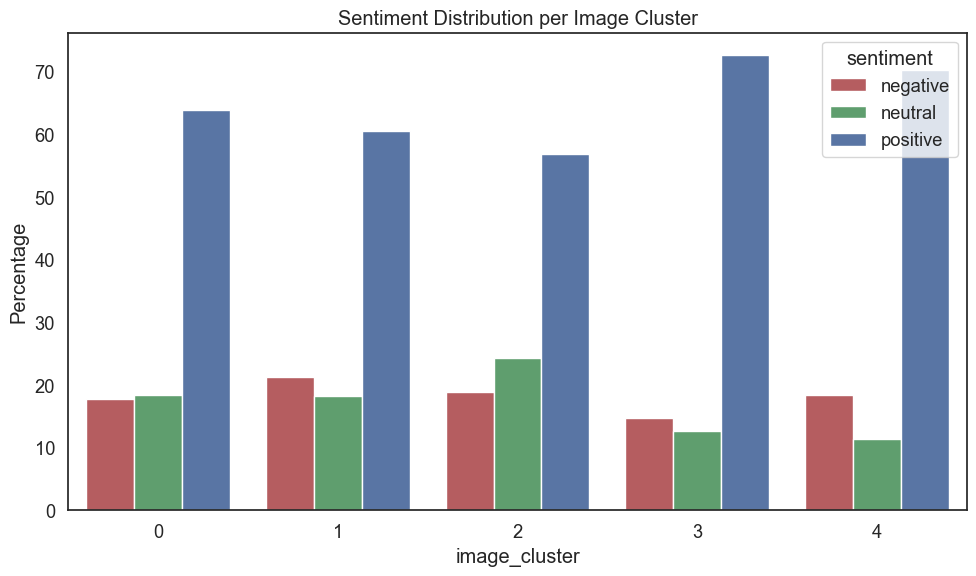

In [107]:
img_sent_dist = (
    df.groupby(['image_cluster', 'sentiment'])
    .size()
    .reset_index(name='count')
)

# Normalize to percentage
img_sent_dist['percentage'] = img_sent_dist.groupby('image_cluster')['count'].transform(lambda x: 100 * x / x.sum())

plt.figure(figsize=(10, 6))
sns.barplot(data=img_sent_dist, x='image_cluster', y='percentage', hue='sentiment',
            palette={"positive": "#4c72b0", "neutral": "#55a868", "negative": "#c44e52"})
plt.title("Sentiment Distribution per Image Cluster")
plt.ylabel("Percentage")
plt.tight_layout()
plt.savefig("sentiment_by_image_cluster.png", dpi=300)
plt.show()

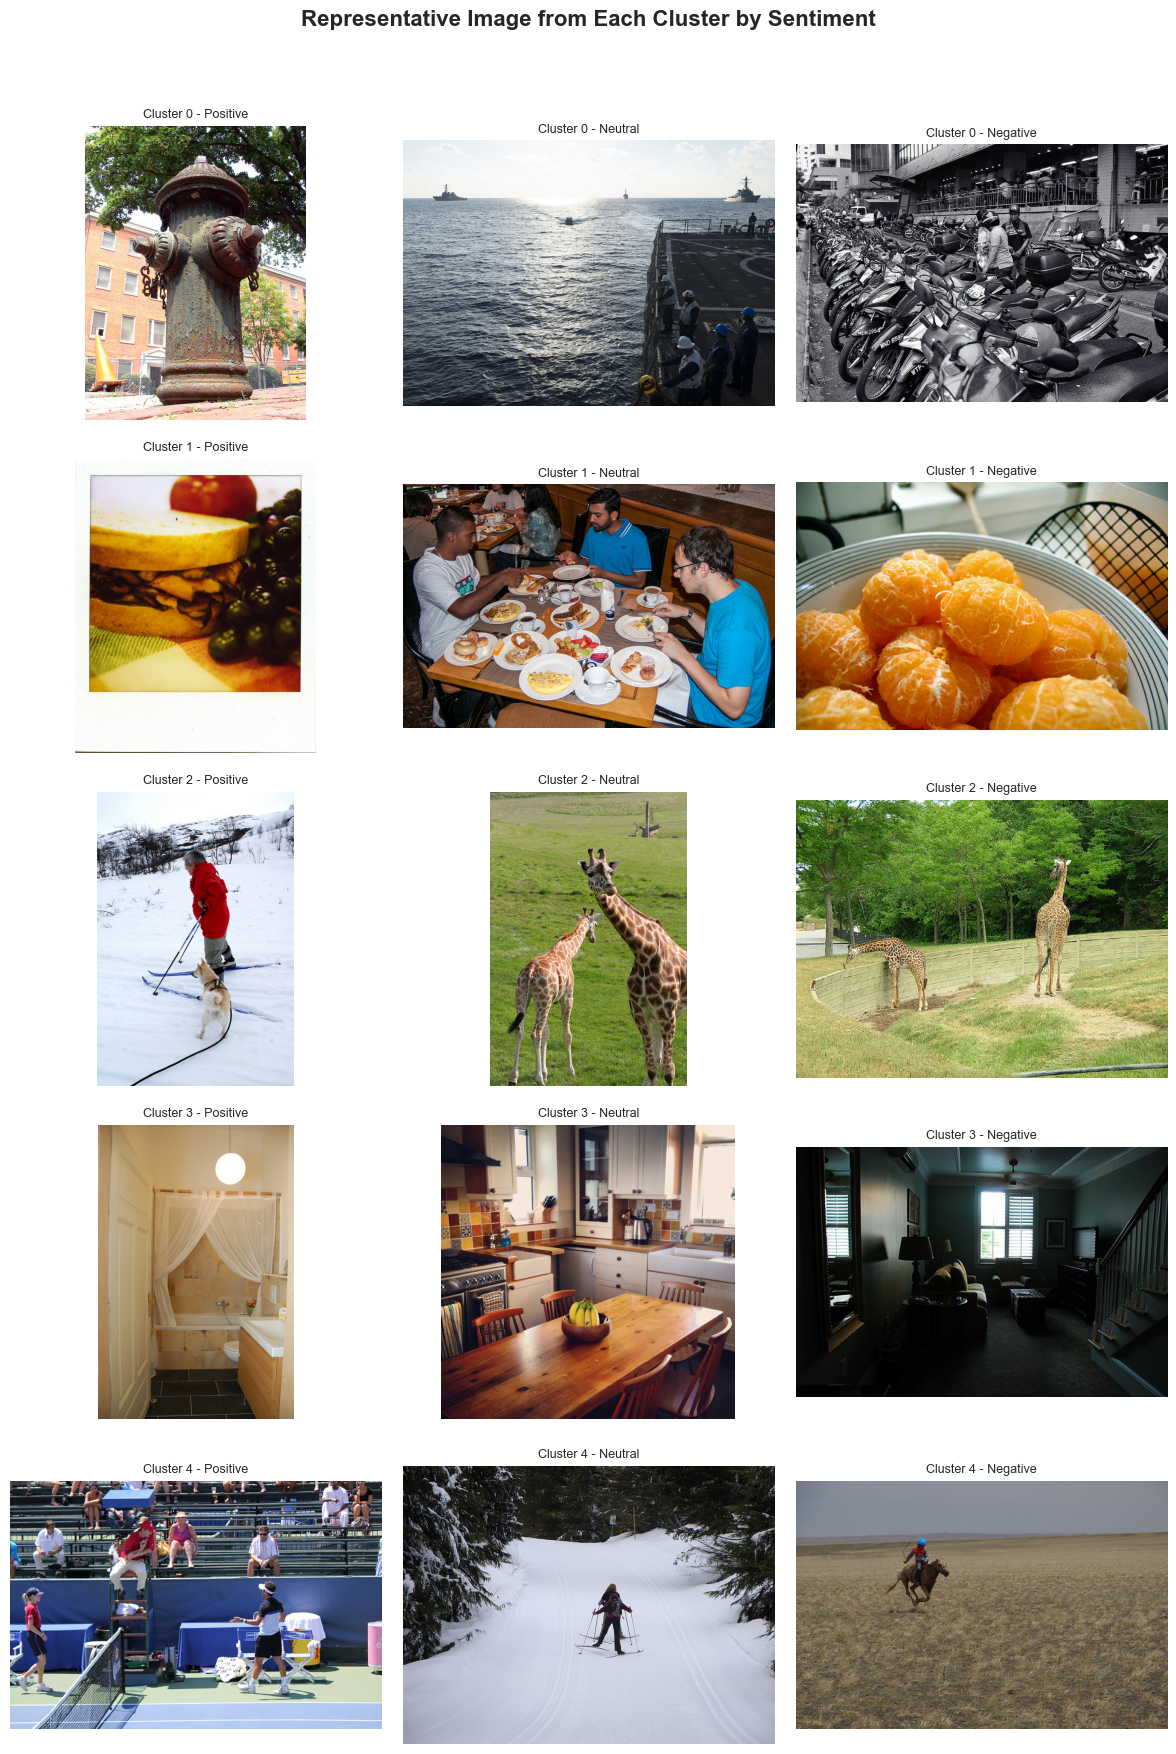

In [113]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Set up image path
image_folder = "/Users/sanakhan/Desktop/val2017"

sentiments = ['positive', 'neutral', 'negative']
fig, axs = plt.subplots(5, 3, figsize=(12, 18))  # 5 clusters × 3 sentiments
fig.suptitle("Representative Image from Each Cluster by Sentiment", fontsize=16, weight="bold")

for cluster_id in range(5):
    for i, sentiment in enumerate(sentiments):
        subset = df[(df['image_cluster'] == cluster_id) & (df['sentiment'] == sentiment)]
        if not subset.empty:
            row = subset.sample(1, random_state=cluster_id * 10 + i).iloc[0]
            image_id = int(row['image_id'])
            caption = row['caption']
            img_path = os.path.join(image_folder, f"{image_id:012}.jpg")

            img = Image.open(img_path)
            ax = axs[cluster_id, i]
            ax.imshow(img)
            ax.set_title(f"Cluster {cluster_id} - {sentiment.capitalize()}", fontsize=9)
            ax.axis('off')
        else:
            # If no image of this sentiment exists for this cluster
            axs[cluster_id, i].axis('off')
            axs[cluster_id, i].set_title(f"Cluster {cluster_id} - {sentiment.capitalize()}\n(No sample)", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("image_cluster_examples_by_sentiment.png", dpi=300)
plt.show()